# Problem Set 5
### by Daniel Tracht, February 2019

## Problem 1

In this problem, we will be using the same data on incomes of graduates from the MACSS program as in the previous data set.  We will also be using the log normal distribution as before.

### Part a

We want to plot a histogram of the income data:

In [54]:
# Import the necessary libraries
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
#cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook

import requests
from IPython.display import Image

# Download and save the data file incomes.txt
url = ('https://raw.githubusercontent.com/dtracht/persp-model-econ_W19/' +
       'master/ProblemSets/PS4/data/incomes.txt')
data_file = requests.get(url, allow_redirects=True)
open('data/incomes.txt', 'wb').write(data_file.content)

# Load the data as a NumPy array
pts = np.loadtxt('data/incomes.txt')

<IPython.core.display.Javascript object>


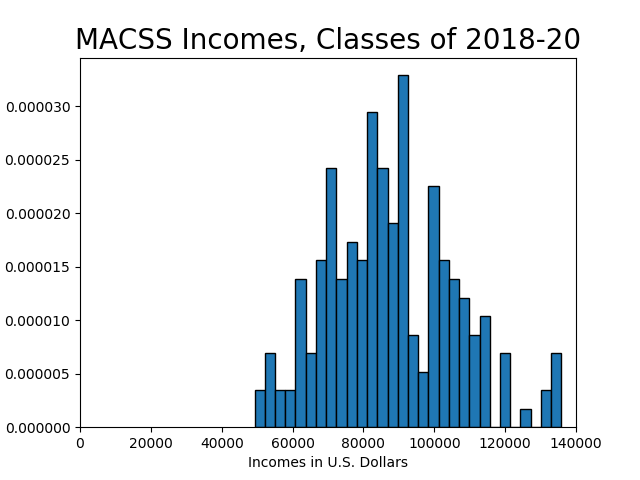

In [55]:
import matplotlib.pyplot as plt

num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])

plt.show()

### Part b
We want to estimate the parameters of the log normal distribution through  generalized method of moments estimation.  We will use the average income and standard deviation of income as our two moments.  We will use the identity matrix as our weighting matrix.

In [72]:
# takes vector of x values, parameters for mu and sigma
# returns vector of pdf values for the lognormal
from scipy.stats import lognorm
def lognormal_pdf (xvals, mu, sigma):
    pdf_vals = (1 / (xvals * sigma * np.sqrt(2 * np.pi))) * np.exp (-(np.log(xvals)-mu)**2 / (2 * sigma**2))
    #take pdf values that are rounded to zero and reset them to very low
    #pdf_zero = pdf_vals==0
    #pdf_vals[pdf_zero] = 1e-16
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    return mean_data, var_data

def model_moments(mu, sigma):
    xfx = lambda x: x * lognormal_pdf(x, mu, sigma)
    # integrating over to an order more than the upper bound of the data
    (mean_model, m_m_err) = intgr.quad(xfx, 1e-10, 1400000)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognormal_pdf(x, mu, sigma) 
    (var_model, v_m_err) = intgr.quad(x2fx, 1e-10, 1400000)
    return mean_model, var_model

def err_vec(xvals, mu, sigma, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [73]:
import scipy.optimize as opt

# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.359646572032204  sig_GMM1= 0.203781329888945


We wish to plot the estimated lognormal PDF against the histogram in part a:

<IPython.core.display.Javascript object>


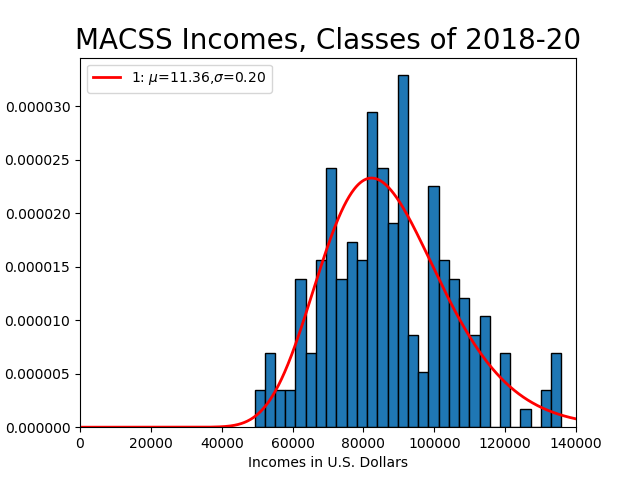

In [75]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='1: $\mu$=11.36,$\sigma$=0.20')
plt.legend(loc='upper left')

plt.show()

We want the value of the criterion function at the estimated GMM parameters.  We also want to compare the data moments to the model moments at the estimated parameter values:

In [76]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, False).reshape(2,)
crit_val = err1.T @ W_hat @ err1
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
print("Criterion value at estimated parameters=", crit_val)

Mean of points = 87588.93076851241 , Variance of points = 325293935.07555556
Mean of model = 87588.9377219922 , Variance of model = 325293918.8103683
Error vector= [ 7.93876547e-08 -5.00015079e-08]
Criterion value at estimated parameters= 8.802550517089305e-15


### Part c
We wish to perform a two-step GMM procedure by using the estimates from above to generate an estimator for the variance covariance matrix
$$
\hat{{\Omega}}_{2step}
$$
which we then use to get the optimal weighting matrix
$$
\hat{W}_{2step}:
$$

In [77]:
def get_Err_mat2(pts, mu, sigma, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    return Err_mat

In [78]:
# starting with the results above
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.04240113 0.07326092]
 [0.07326092 1.86696273]]
[[25.29959633 -0.99277376]
 [-0.99277376  0.57458646]]


In [79]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.359646572032204  sig_GMM2= 0.203781329888945


As expected, the point estimates of the parameters are the same as above.  We wish to see the value of the criterion function at the estimated parameters, as well as compare the data moments to the model moments at the generated parameter:

In [90]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(pts, mu_GMM2, sig_GMM2, False).reshape(2,)
crit_val = err2.T @ W_hat2 @ err2
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err2)
print("Criterion value at estimated parameters=", crit_val)

Mean of points = 87588.93076851241 , Variance of points = 325293935.07555556
Mean of model = 87588.9377219922 , Variance of model = 325293918.8103683
Error vector= [ 7.93876547e-08 -5.00015079e-08]
Criterion value at estimated parameters= 1.6876635749813208e-13


We also want to plot the PDF of the lognormal distribution for the estimated parameters as well as the histogram of the actual data and the PDF of the lognormal distribution from part b:

<IPython.core.display.Javascript object>


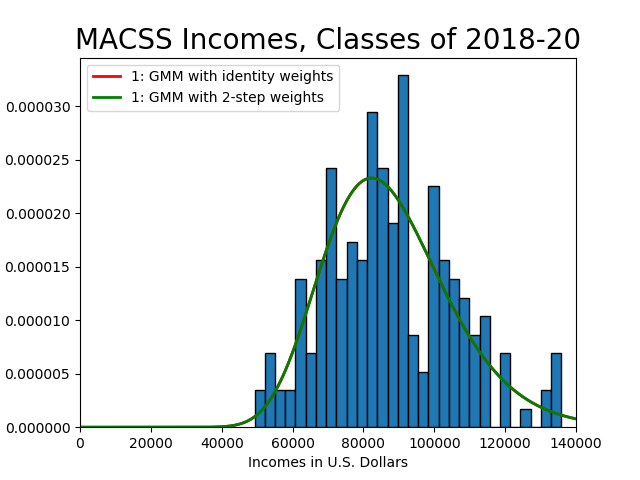

In [81]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='1: GMM with identity weights')
plt.legend(loc='upper left')

plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM2, sig_GMM2),
         linewidth=2, color='g', label='1: GMM with 2-step weights')
plt.legend(loc='upper left')


plt.show()

### Part d
We wish to estimate the lognormal PDF to fit the data using GMM on different moments.  In this part, we will use the percents of indviduals earning less than 75,000 dollars, between 75 and 100 thousand dollars, and more than 100 thousand dollars:

In [91]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma):
    xfx = lambda x: lognormal_pdf(x, mu, sigma)
    # lower bound near 0
    # upper bound an order higher than top of data
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-10, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 1000000, 1400000)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod,

def err_vec3(xvals, mu, sigma, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion3(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err 
    return crit_val

In [83]:
# starting at parameters from above
mu_init = mu_GMM2
sig_init = mu_GMM2
params_init = np.array([mu_init, sig_init])
W_hat1_3 = np.eye(3)
gmm_args = (pts, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


mu_GMM1_3= 16.724460807976826  sig_GMM1_3= 8.639553097534485


We wish to see the value of the criterion function at the estimated parameters, as well as compare the data moments to the model moments at the generated parameters:

In [94]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(pts)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM1_3, sig_GMM1_3)
err1_3 = err_vec3(pts, mu_GMM1_3, sig_GMM1_3, False).reshape(3,)
crit_val_3 = err1_3.T @ W_hat1_3 @ err1_3
print('Percent lower than 75k in data =', bpct_1_dat, ', in model =', bpct_2_mod)
print('Percent between 75k and 100k in data =', bpct_2_dat, ', in model =', bpct_2_mod)
print('Percent above 100k in data =', bpct_3_dat, ', in model =', bpct_3_mod)
print('Error vector=', err1_3)
print("Criterion value at estimated parameters=", crit_val_3)

[-0.01048739 -0.97692244 -0.94317786]
Percent lower than 75k in data = 0.265 , in model = 0.010961842605117358
Percent between 75k and 100k in data = 0.475 , in model = 0.010961842605117358
Percent above 100k in data = 0.26 , in model = 0.014773756404200243
Error vector= [-0.01048739 -0.97692244 -0.94317786]
Criterion value at estimated parameters= 1.8440719080829635


We also want to plot the PDF of the lognormal distribution for the estimated parameters as well as the histogram of the actual data:

<IPython.core.display.Javascript object>


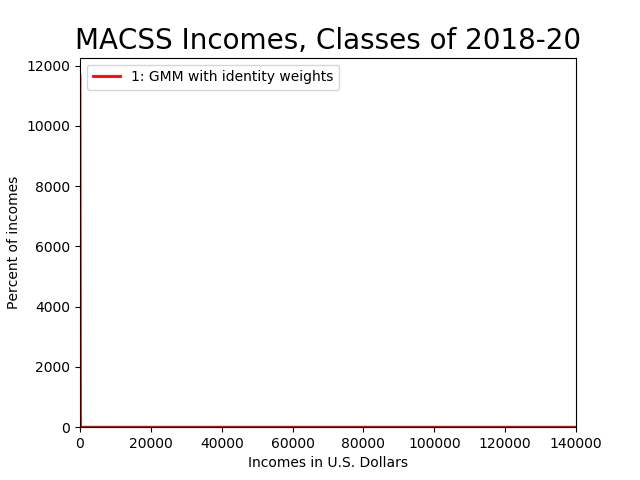

In [84]:
# Plot histogram with the estimated PDF
num_bins = 30
# normed option has been deprecated
# using density=True instead
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title("MACSS Incomes, Classes of 2018-20", fontsize=20)
plt.xlabel("Incomes in U.S. Dollars")
plt.ylabel("Percent of incomes")
plt.xlim([0,140000])


dist_pts = np.linspace(1e-10, 140000, 1000)
plt.plot(dist_pts, lognormal_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3),
         linewidth=2, color='r', label='1: GMM with identity weights')
plt.legend(loc='upper left')

plt.show()

## 5. Examples
In this section, we will use GMM to estimate parameters of the models from the [maximum likelihood estimation notebook](https://github.com/rickecon/Notebooks/blob/master/MLE/MLest.ipynb). We will also go through the standard moment conditions in most econometrics textbooks in which the conditional and unconditional expectations provide moments for estimation.

Now let's define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix $\hat{W}$.

In [ ]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Now we can perform the GMM estimation. Let's start with the identity matrix as our estimate for the optimal weighting matrix $W = I$.

In [ ]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 60
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, 0.0, 450.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

In [ ]:
mean_data, var_data = data_moments(pts)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 450.0)
err1 = err_vec(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
results

#### 5.1.2. Two moments, two-step optimal weighting matrix
Similar to the ML problem, it looks like the criterion function is roughly equal for a specific portion increase of $\mu$ and $\sigma$ together. That is, with these two moments probably have a correspondence of values of $\mu$ and $\sigma$ that give roughly the same criterion function value. This issue has two possible solutions.

1. Maybe we need the two-step variance covariance estimator to calculate a "more" optimal weighting matrix $W$.
2. Maybe our two moments aren't very good moments for fitting the data.

Let's first try the two-step weighting matrix.

In [ ]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded
    R = 2.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    R          = integer = 2, hard coded number of moments
    N          = integer >= R, number of data observations
    Err_mat    = (R, N) matrix, error by moment and observation data
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: Err_mat
    --------------------------------------------------------------------
    '''
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

In [ ]:
Err_mat = get_Err_mat2(pts, mu_GMM1, sig_GMM1, 0.0, 450.0, False)
VCV2 = (1 / pts.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

In [ ]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 60
params_init = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (pts, 0.0, 450.0, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

Look at how much smaller (more efficient) the estimated standard errors are in this case with the two-step optimal weighting matrix $\hat{W}_{2step}$.

In [ ]:
d_err2_2 = Jac_err2(pts, mu_GMM2, sig_GMM2, 0.0, 450.0, False)
print(d_err2_2)
print(W_hat2)
SigHat2_2 = (1 / N) * lin.inv(d_err2.T @ W_hat2 @ d_err2)
print(SigHat2_2)
print('Std. err. mu_hat=', np.sqrt(SigHat2_2[0, 0]))
print('Std. err. sig_hat=', np.sqrt(SigHat2_2[1, 1]))

#### 5.1.3. Four moments, identity weighting matrix
Using a better weighting matrix didn't improve our estimates or fit very much it did improve the standard errors of our estimates. To get the right fit, we might need to choose different moments. Let's try an overidentified model $K<R$, where we estimate $\mu$ and $\sigma$ of the truncated normal distribution $K=2$ using the following four moments $R=4$.

1. The percent of observations greater than 430 (between 430 and 450)
2. The percent of observations between 320 and 430
3. The percent of observations between 220 and 320
4. The percent of observations less than 220 (between 0 and 220)

In [ ]:
def data_moments4(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 220
    bpct_2_dat = scalar in [0, 1], percent of observations
                 220 <= x < 320
    bpct_3_dat = scalar in [0, 1], percent of observations
                 320 <= x < 430
    bpct_4_dat = scalar in [0, 1], percent of observations
                 430 <= x <= 450

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3, bpct_4
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 220].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=220) & (xvals < 320)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=320) & (xvals < 430)].shape[0] /
                  xvals.shape[0])
    bpct_4_dat = xvals[xvals >= 430].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat


def model_moments4(mu, sigma, cut_lb, cut_ub):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3, binpct_4).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    bpct_4_mod = scalar in [0, 1], percent of model observations in
                 bin 4
    bp_4_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_4_mod
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 220)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 220, 320)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 320, 430)
    (bpct_4_mod, bp_4_err) = intgr.quad(xfx, 430, 450)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod


def err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat, bpct_4_dat = \
        data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat],
                          [bpct_4_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod, bpct_4_mod = \
        model_moments4(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod],
                          [bpct_4_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion4(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec4(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

Let's see what the model moments would be relative to the data moments with the first GMM estimates $mu\approx 620$ and $\sigma\approx 198$ from the previous 2-moment estimation. Let's also look at the resulting criterion function at those values.

In [ ]:
params = np.array([mu_GMM1, sig_GMM1])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(mu_GMM1, sig_GMM1, 0.0, 450))
print(criterion4(params, pts, 0.0, 450.0, np.eye(4)))

In [ ]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 400
sig_init = 70
params_init = np.array([mu_init, sig_init])
W_hat1_4 = np.eye(4)
gmm_args = (pts, 0.0, 450.0, W_hat1_4)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('mu_GMM1_4=', mu_GMM1_4, ' sig_GMM1_4=', sig_GMM1_4)

In [ ]:
params = np.array([mu_GMM1_4, sig_GMM1_4])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(mu_GMM1_4, sig_GMM1_4, 0.0, 450))
print(criterion4(params, pts, 0.0, 450.0, W_hat1_4))

In [ ]:
params2 = np.array([350, 98])
print('params=', params)
print(data_moments4(pts))
print(model_moments4(350, 98, 0.0, 450))
print(criterion4(params2, pts, 0.0, 450.0, W_hat1_4))

In [ ]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(pts, num_bins, density=True,
                                edgecolor='k')
plt.title('Econ 381 scores: 2011-2012', fontsize=20)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of scores')
plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 450, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, 400, 70, 0.0, 450),
         linewidth=2, color='g', label='1: $\mu=400$,$\sigma=70$')
plt.legend(loc='upper left')

We can compute the estimator of the variance-covariance matrix $\hat{\Sigma}$ of the GMM parameter estimator by computing the Jacobian of the error vector. In this case, the Jacobian $d(x|\theta)$ is $R\times K = 4\times 2$.

In [ ]:
def Jac_err4(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    This function computes the Jacobian matrix of partial derivatives of the R x 1 moment
    error vector e(x|theta) with respect to the K parameters theta_i in the K x 1 parameter vector
    theta. The resulting matrix is R x K Jacobian.
    '''
    Jac_err = np.zeros((4, 2))
    h_mu = 1e-8 * mu
    h_sig = 1e-8 * sigma
    Jac_err[:, 0] = \
        ((err_vec4(xvals, mu + h_mu, sigma, cut_lb, cut_ub, simple) -
          err_vec4(xvals, mu - h_mu, sigma, cut_lb, cut_ub, simple)) / (2 * h_mu)).flatten()
    Jac_err[:, 1] = \
        ((err_vec4(xvals, mu, sigma + h_sig, cut_lb, cut_ub, simple) -
          err_vec4(xvals, mu, sigma - h_sig, cut_lb, cut_ub, simple)) / (2 * h_sig)).flatten()
    
    return Jac_err

In [ ]:
d_err4 = Jac_err4(pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450.0, False)
print(d_err4)
print(W_hat1_4)
SigHat4 = (1 / N) * lin.inv(d_err4.T @ W_hat1_4 @ d_err4)
print(SigHat4)
print('Std. err. mu_hat=', np.sqrt(SigHat4[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat4[1, 1]))

Note how much tighter the standard errors are here with these four moments than they were in the econometric models of Sections 5.1.1 and 5.1.2 with two moments.

#### 5.1.4. Four moments, two-step optimal weighting matrix
Let's see how much things change if we use the two-step estimator for the optimal weighting matrix $W$ instead of the identity matrix.

In [ ]:
def get_Err_mat4(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    '''
    --------------------------------------------------------------------
    This function computes the R x N matrix of errors from each
    observation for each moment. In this function, we have hard coded
    R = 4.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    R          = 2, hard coded number of moments
    N          = integer >= R, number of data observations
    Err_mat    = (R, N) matrix, error by moment and observation data
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: Err_mat
    --------------------------------------------------------------------
    '''
    R = 4
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod, pct_4_mod = \
        model_moments4(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 220
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 220) & (pts < 320)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = (pts >= 320) & (pts < 430)
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
        pts_in_grp4 = pts >= 430
        Err_mat[3, :] = pts_in_grp4 - pct_4_mod
    else:
        pts_in_grp1 = pts < 220
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 220) & (pts < 320)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = (pts >= 320) & (pts < 430)
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
        pts_in_grp4 = pts >= 430
        Err_mat[3, :] = (pts_in_grp4 - pct_4_mod) / pct_4_mod
    
    return Err_mat

In [ ]:
Err_mat4 = get_Err_mat4(pts, mu_GMM1_4, sig_GMM1_4, 0.0, 450.0, True)
VCV2_4 = (1 / pts.shape[0]) * (Err_mat4 @ Err_mat4.T)
print(VCV2_4)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_4 = lin.pinv(VCV2_4)
print(W_hat2_4)

In [ ]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 600
sig_init = 196
params_init = np.array([mu_GMM1_4, sig_GMM1_4])
gmm_args = (pts, 0.0, 450.0, W_hat2_4)
results2_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_4, sig_GMM2_4 = results2_4.x
print('mu_GMM2_4=', mu_GMM2_4, ' sig_GMM2_4=', sig_GMM2_4)
results2_4

In this case, the two-step estimator of the optimal weighting matrix creates a small change in the estimated $\mu$ and $\sigma$ paramters to $(\mu=364,\sigma=111)$ from $(\mu=362,\sigma=92)$ in the identity matrix estimation. The criterion function for different values of $\mu$ and $\sigma$ here has a clear minimum in a certain area. But it also has some really interesting nonlinearities.

In [ ]:
# Note that this will take a few minutes because the intgr.quad() commands
# are a little slow
# mu_vals = np.linspace(355, 370, 50)
# sig_vals = np.linspace(85, 120, 50)
mu_vals = np.linspace(60, 700, 50)
sig_vals = np.linspace(20, 200, 50)
crit_vals4 = np.zeros((50, 50))
for mu_ind in range(50):
    for sig_ind in range(50):
        crit_vals4[mu_ind, sig_ind] = \
            criterion4(np.array([mu_vals[mu_ind], sig_vals[sig_ind]]),
                       pts, 0.0, 450.0, W_hat2_4)

mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, crit_vals4, rstride=8,
                cstride=1, cmap=cmap1)
ax.set_title('Criterion function for values of mu and sigma')
ax.set_xlabel(r'$\sigma$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'Crit. func.')

We can compute the estimator of the variance-covariance matrix $\hat{\Sigma}$ of the GMM parameter estimator by computing the Jacobian of the error vector.

In [ ]:
d_err4_2 = Jac_err4(pts, mu_GMM2_4, sig_GMM2_4, 0.0, 450.0, False)
print(d_err4_2)
print(W_hat2_4)
SigHat4_2 = (1 / N) * lin.inv(d_err4_2.T @ W_hat2_4 @ d_err4_2)
print(SigHat4_2)
print('Std. err. mu_hat=', np.sqrt(SigHat4_2[0, 0]))
print('Std. err. sigma_hat=', np.sqrt(SigHat4_2[1, 1]))

Note how much smaller (more efficient) the estimated standard errors are in this case with the two-step optimal weighting matrix $\hat{W}_{2step}$: $(1.65, 1.49)$ versus $(3.78, 3.24)$.